# Лабораторная 7. Сентимент-анализ

Задачи классификации текста аналогично обычной задаче классификации предполагает присвоение метки класса некоторому тексту. Здесь можно действовать любыми методами для того, чтобы классифицировать текст, но мы пойдем по следующему пути: векторизуем последовательности (обязательно почитайте про подходы к векторизации, об эмбеддингах) и обучим RNN

После обучения базовых моделей разрешается использовать любой другой подход

За выполнение базовой работы можно получить 15 баллов, за преодоление отметки в 94% точности классификации еще 5 баллов
Удачи!

Примечание: обязательно почитайте про лемматизацию, стеминг, TF-IDF и Word2Vec подходы

In [83]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm 


import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re 
from collections import Counter
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from gensim.models import Word2Vec
import torch 
import torch.nn as nn  
from torch.optim import Adam
from torch.utils.data import DataLoader , TensorDataset

lemma = WordNetLemmatizer()
lb = LabelEncoder()

In [84]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [85]:
df = pd.read_csv('twitter_training.csv', header=None)
df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [49]:
np.unique(df[1])

array(['Amazon', 'ApexLegends', 'AssassinsCreed', 'Battlefield',
       'Borderlands', 'CS-GO', 'CallOfDuty', 'CallOfDutyBlackopsColdWar',
       'Cyberpunk2077', 'Dota2', 'FIFA', 'Facebook', 'Fortnite', 'Google',
       'GrandTheftAuto(GTA)', 'Hearthstone', 'HomeDepot',
       'LeagueOfLegends', 'MaddenNFL', 'Microsoft', 'NBA2K', 'Nvidia',
       'Overwatch', 'PlayStation5(PS5)',
       'PlayerUnknownsBattlegrounds(PUBG)', 'RedDeadRedemption(RDR)',
       'TomClancysGhostRecon', 'TomClancysRainbowSix', 'Verizon',
       'WorldOfCraft', 'Xbox(Xseries)', 'johnson&johnson'], dtype=object)

In [50]:
df = df.drop(0 , axis=1)

In [51]:
df= df.rename(columns={1:"Feature2",3:"Feature1",2: "labels"})

In [52]:
df.head()

,Feature2,labels,Feature1
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [53]:
df["tweets"]= df["Feature1"].astype(str) +" "+ df["Feature2"].astype(str)
df= df.drop(["Feature1","Feature2"],axis=1)
df.head()

,labels,tweets
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [54]:
df_labels = {key : value for value , key in enumerate(np.unique(df['labels']))}
df_labels

{'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}

In [55]:
def getlabel(n) : 
    for x , y in df_labels.items() : 
        if y==n : 
            return x

In [56]:
def DataPrep(text): 
    text = re.sub('<.*?>', '', text) # HTML tags
    text = re.sub(r'\d+', '', text) # numbers
    text = re.sub(r'[^\w\s]', '', text) # special characters
    text = re.sub(r'http\S+', '', text) # URLs or web links
    text = re.sub(r'@\S+', '', text) # mentions
    text = re.sub(r'#\S+', '', text) # hashtags
    
    # tokenization 
    tokens = nltk.word_tokenize(text) 
    
    # remove puncs 
    punc = list(punctuation)
    words = [word for word in tokens if word not in punc]
    
    # remove stopwords 
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word.lower() in stop_words]
    
    # Lemmatization 
    words = [lemma.lemmatize(word) for word in words] 
    
    text = ' '.join(words)
    
    return text

In [57]:
df['cleaned_tweets'] = df['tweets'].apply(DataPrep)

In [58]:
print(f'There are around {int(df["cleaned_tweets"].duplicated().sum())} duplicated tweets, we will remove them.')
df.drop_duplicates("cleaned_tweets", inplace=True)
df['tweet_len'] = [len(text.split()) for text in df.cleaned_tweets]
df = df[df['tweet_len'] < df['tweet_len'].quantile(0.995)]

There are around 11865 duplicated tweets, we will remove them.


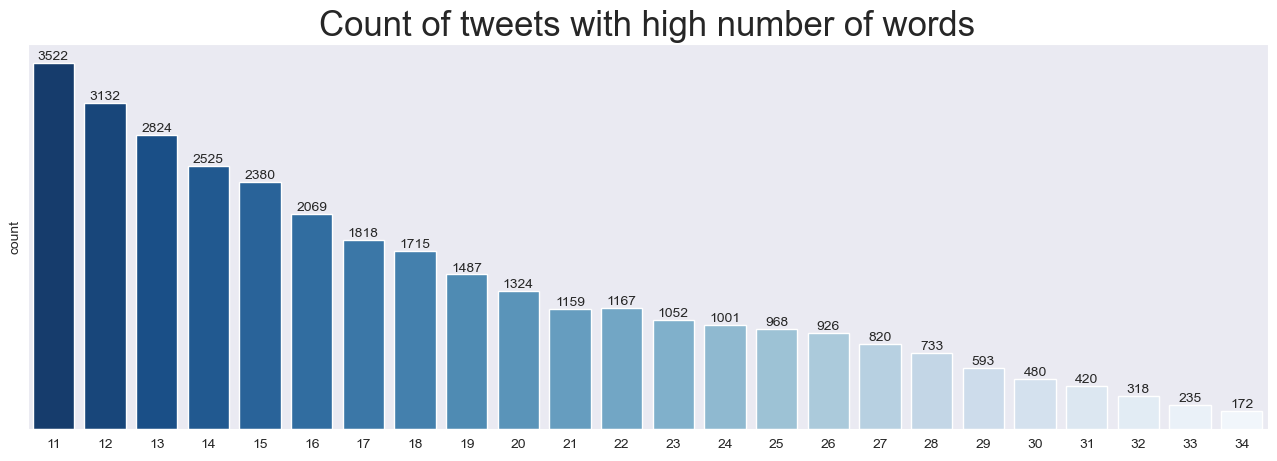

In [59]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='tweet_len', data=df[(df['tweet_len']<=1000) & (df['tweet_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

## Обучаем модели

In [60]:
MAX_LEN = np.max(df['tweet_len'])

In [61]:
def lstm_prep(column , seq_len) : 
    # create a vocab of words 
    corpus = [word for text in column for word in text.split()]
    words_count = Counter(corpus) 
    sorted_words = words_count.most_common()
    vocab_to_int = {w:i+1 for i , (w,c) in enumerate(sorted_words)}
    
    text_int = [] 
    
    for text in column : 
        token = [vocab_to_int[word] for word in text.split()]
        text_int.append(token)
        
        
    # padding 
    features = np.zeros((len(text_int) , seq_len) , dtype = int)
    for idx , y in tqdm(enumerate(text_int)) : 
        if len(y) <= seq_len : 
            zeros = list(np.zeros(seq_len - len(y)))
            new = zeros + y
            
        else : 
            new = y[:seq_len]
            
        features[idx,:] = np.array(new)
        
    return sorted_words, features

In [62]:
VOCAB , tokenized_column = lstm_prep(df['cleaned_tweets'] , MAX_LEN)

0it [00:00, ?it/s]

In [63]:
VOCAB[:10]

[('game', 8616),
 ('like', 4206),
 ('Im', 3715),
 ('Microsoft', 3635),
 ('Facebook', 3633),
 ('get', 3621),
 ('Amazon', 3456),
 ('Verizon', 3411),
 ('Google', 3266),
 ('Battlefield', 3133)]

In [64]:
tokenized_column.shape

(62400, 34)

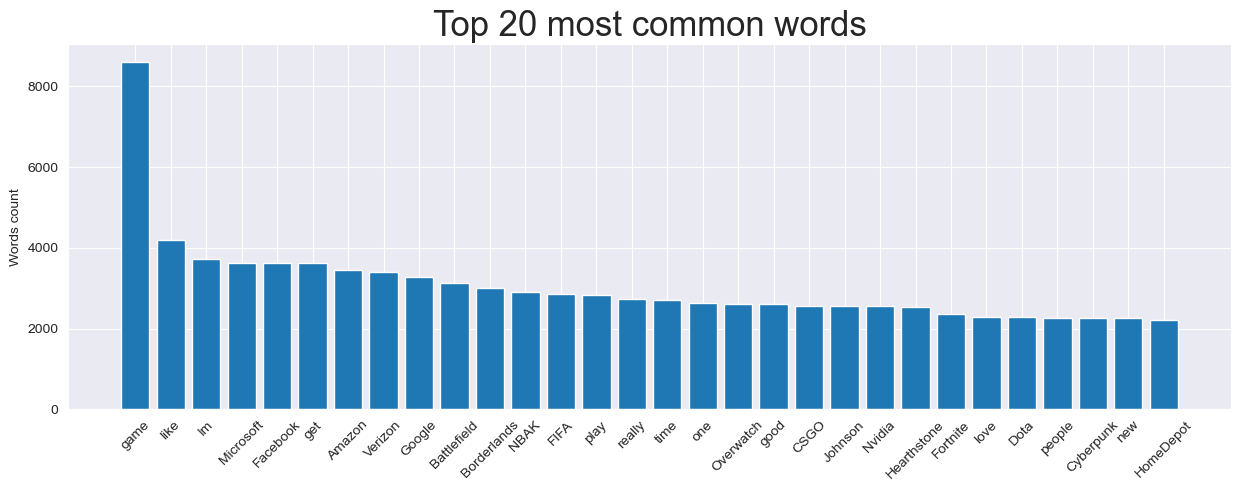

In [65]:
def most_common_words(vocab) : 
    keys = [] 
    values = [] 
    for key , value in vocab[:30] : 
        keys.append(key) 
        values.append(value)
        
    plt.figure(figsize=(15, 5))
    ax = plt.bar(keys, values)
    plt.title('Top 20 most common words', size=25)
    plt.ylabel("Words count")
    plt.xticks(rotation=45)
    plt.subplots_adjust(bottom=0.15)
    plt.show()
    
most_common_words(VOCAB)

In [66]:
X = tokenized_column
y = lb.fit_transform(df['labels'].values)

In [67]:
X_train , X_val , Y_train , Y_val = train_test_split(X , y , train_size=0.85 , random_state=42)

In [68]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.LongTensor(Y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.LongTensor(Y_val))

In [69]:
BATCH_SIZE = 64
train_dataloader = DataLoader(
    dataset = train_data , 
    batch_size=BATCH_SIZE , 
    shuffle=True
)
val_dataloader = DataLoader(
    dataset = val_data , 
    batch_size = BATCH_SIZE , 
    shuffle=False
)

In [70]:
EMBEDDING_DIM = 200

In [71]:
Word2vec_train_data = list(map(lambda x: x.split(), df['cleaned_tweets']))
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [72]:
def weight_matrix(model,vocab):
    vocab_size= len(vocab)+1
    embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIM))
    for word, token in vocab:
        if model.wv.__contains__(word):
            embedding_matrix[token]=model.wv.__getitem__(word)
    return embedding_matrix

In [73]:
embedding_vec = weight_matrix(word2vec_model,VOCAB)
print("Embedding Matrix Shape:", embedding_vec.shape)

Embedding Matrix Shape: (43349, 200)


In [74]:
def param_count(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print('The Total number of parameters in the model : ', sum(params))

In [75]:
class Model(nn.Module) : 
    def __init__(self , vocab_size , embedding_dim 
                 , num_layers , hidden_dim , out_channels , bidirectional, device='cpu') : 
        super().__init__() 
        print(device)
        self.no_layers = num_layers 
        self.hidden_dim = hidden_dim 
        self.out_channels = out_channels
        self.num_directions = 2 if bidirectional else 1  
        self.embedding = nn.Embedding(vocab_size , embedding_dim)
        self.embedding = self.embedding.to(device)
        self.device = device
        self.lstm = nn.LSTM(
            embedding_dim , 
            hidden_dim , 
            num_layers , 
            dropout = 0.5 , 
            bidirectional = bidirectional , 
            batch_first = True
        )
        self.lstm = self.lstm.to(device)
        
        self.fc = nn.Linear(hidden_dim*self.num_directions , out_channels)
        self.fc = self.fc.to(device)
        
        
    def forward(self , x) : 
        h0 = torch.zeros((self.no_layers * self.num_directions , x.size(0) , self.hidden_dim)).to(self.device)
        c0 = torch.zeros((self.no_layers * self.num_directions , x.size(0) , self.hidden_dim)).to(self.device)
        
        embedded = self.embedding(x)
        
        out , _ = self.lstm(embedded , (h0 , c0))
        
        out = out[:,-1,:]
        
        out = self.fc(out)
        
        return out 

In [76]:
VOCAB_SIZE = len(VOCAB) + 1
NUM_LAYERS = 2 
OUT_CHANNELS = 4 
HIDDEN_DIM = 256
BIDIRECTIONAL = True
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Model(VOCAB_SIZE , EMBEDDING_DIM , NUM_LAYERS , HIDDEN_DIM , OUT_CHANNELS , BIDIRECTIONAL, DEVICE)

model.embedding.weight.data.copy_(torch.from_numpy(embedding_vec))

model.embedding.weight.requires_grad = True

if torch.cuda.is_available():
    model = model.cuda()

cpu


In [77]:
param_count(model)

The Total number of parameters in the model :  11186796


In [78]:
criterion=nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=0.001)

epochs = 10 
training_loss = []
training_acc = [] 
for i in tqdm(range(epochs)) : 
    epoch_loss = 0
    epoch_acc = 0 
    for batch , (x_train , y_train) in enumerate(train_dataloader) :
        x_train , y_train = x_train.to(DEVICE), y_train.to(DEVICE)
        y_pred = model(x_train)
        
        loss = criterion(y_pred , y_train) 
        
        if batch % 500 == 0:
            print(f"Looked at {batch * len(x_train)}/{len(train_dataloader.dataset)} samples.")
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss +=loss 
        epoch_acc += accuracy_score(y_train.cpu() , y_pred.argmax(dim=1).cpu())
        
    training_loss.append((epoch_loss/len(train_dataloader)).detach().cpu().numpy())
    training_acc.append(epoch_acc/len(train_dataloader))
    
    print(f"Epoch {i+1}: Accuracy: {(epoch_acc/len(train_dataloader)) * 100}, Loss: {(epoch_loss/len(train_dataloader))}\n\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Looked at 0/53040 samples.
Looked at 32000/53040 samples.
Epoch 1: Accuracy: 63.26397265782068, Loss: 0.8890261650085449


Looked at 0/53040 samples.
Looked at 32000/53040 samples.
Epoch 2: Accuracy: 89.15108564535585, Loss: 0.3133517801761627


Looked at 0/53040 samples.
Looked at 32000/53040 samples.
Epoch 3: Accuracy: 94.32046642541214, Loss: 0.1651126891374588


Looked at 0/53040 samples.
Looked at 32000/53040 samples.


KeyboardInterrupt: 

## Время Prediction

In [ ]:
test_df = pd.read_csv('twitter_validation.csv', header=None)
print(test_df.head())
test_df = test_df.drop(0 , axis=1)

test_df = test_df.rename(columns={1:"Feature2",3:"Feature1",2: "labels"})
test_df.head()

In [ ]:
test_df["tweets"]= test_df["Feature1"].astype(str) +" "+ test_df["Feature2"].astype(str)
test_df= test_df.drop(["Feature1","Feature2"],axis=1)

In [ ]:
test_df.head()

In [ ]:
def make_predictions(row) : 
    random_data = row.sample(n=10)
    random_tweets = random_data['tweets'].values
    
    vec = TfidfVectorizer()
    vec.fit(random_data)
    
    cleaned_tweets = [] 
    for tweet in random_tweets : 
        cleaned_tweets.append(DataPrep(tweet))
        
    x_test = vec.transform(cleaned_tweets).toarray()
    
    y_test = random_data['labels'].values
        
    _ , X_test = lstm_prep(cleaned_tweets , MAX_LEN)
    
    X_test = torch.from_numpy(X_test).to(DEVICE)

    lstm_pred = model(X_test)
    lstm_pred = torch.softmax(lstm_pred , dim=1 ).argmax(dim=1)
    pred = np.array([getlabel(lstm_pred[i]) for i in range(len(lstm_pred))])
    for i in tqdm(range(2)) : 
        print(f"The original tweet : {random_tweets[i]}\n")
        print(f"The original label : {y_test[i]}\n")
        print(f"The lstm prediction is : {getlabel(lstm_pred[i])}\n")
        print('-'*120)
    print(accuracy_score(pred, y_test))
    
    
make_predictions(test_df)

## Что дальше?

Попытайтесь улучшить модель (попробуйте GRU), изменить подход к токенизации данных и так далее, удачи!